# Shallow Bayesian sparse coding networks

Here we invesigate Bayesian sparse coding networks consisting only of a single "hidden" layer. We will extend the standard SCN appraoch to a full Bayesian treatment of SCNs. Unlike SCNs where inference and learning relies on MAP estimates for latent variables and MLE estimate for weights, we will formulate Bayesian SCNs with defined prior over weights and the full estimate of the posterior of latent variables and weights.

The investigation is inspired by the following paper: "Illing, Bernd, Wulfram Gerstner, and Johanni Brea. "Biologically plausible deep learning—but how far can we go with shallow networks?." Neural Networks 118 (2019): 90-101". The authors were interested to understand the limitations of shallow networks for image classification, with the aim to test local biologically plaussible learning rules. Sparse coding assumptions leads to biologically plausible neuronal dynamics and hebbian like learning rules.  

Here we will utilise the same paradigm of shallow networks, to test how Bayesian treatment of SCNs changes the performance of classification algorithms. We will start with the following generative model over hidden states $\pmb{a}$ (neuronal activations) and parameter (network weights) $\pmb{W}_1$, and $\pmb{W}_2$

\begin{equation}
   p\left(\pmb{X}, \pmb{A}, \pmb{L}|\pmb{\Theta}\right) = \prod_{n=1}^N p(\pmb{x}^n|\pmb{a}^n, \pmb{\Theta}) p(l^n|\pmb{a}^n, \pmb{\Theta})p(\pmb{a}^n|\pmb{\Theta})
\end{equation}

where

\begin{equation}
    \begin{split}
        p\left(\pmb{x}^n|\pmb{a}^n, \pmb{\Theta}\right) &= \pmb{\mathcal{N}}\left(\pmb{x}^n; \pmb{L}\pmb{W}^T_{1} \pmb{a}^n + \pmb{b}_1, \pmb{L}\pmb{L}^T \right) \\
        p\left(l^n|\pmb{a}^n, \pmb{\Theta}\right) &= \prod_i s_{\max}^i \left( \pmb{w}^T_{2,i} \pmb{a}^n + \pmb{b}_2 \right)^{\delta_{l^n, i}} \\
        p\left(\pmb{a}^n|\pmb{\Theta}\right) &\propto \prod_i e^{-\lambda C(a_i)}\\
    \end{split}
\end{equation}
The MAP estimate with respect to hidden states $\pmb{a}^n$ is obtained as a solution the following system of ODEs

\begin{equation}
\begin{split}
\frac{d \pmb{u}^n}{d t} &= - \pmb{u}^n + \pmb{W}_1 \pmb{\epsilon}_1^n + \pmb{W}_2 \pmb{\epsilon}^n_2 - \pmb{V} \pmb{a}^n \\
a^n_i &= \phi\left(u^n_i\right) = \begin{cases} 0, & \text{ for } u_i^n < \alpha\lambda \\ \frac{u^n_i - \alpha\lambda}{1 + e^{\gamma (u^n_i - \lambda) }},& \text{ for } u^n_i \geq \alpha\lambda \end{cases}
\end{split}
\end{equation}

where $\pmb{V} = \pmb{W}_1 \cdot \pmb{W}_1^T - \pmb{I}$, 
$\pmb{\epsilon}_1^n = \pmb{L}^{-1}\left(\pmb{x}_n - \pmb{b}_1 \right)$, and $\pmb{\epsilon}^n_2 = \pmb{l}^n - \pmb{s}_{\max}\left( \pmb{W}_2^T \pmb{a}^n + \pmb{b}_2 \right), \text{ for } \pmb{l}^n = \text{onehot}(l^n)$


In [1]:
import os
# Set cuda device to use
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

####################
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = "platform"
######################################################

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import equinox as eqx

import jax.numpy as jnp
from functools import partial
from jax import random, vmap, nn
from jax.nn import one_hot
from flax import linen as fnn
from typing import Any, Callable, Sequence, Optional

from numpyro.infer import MCMC, NUTS, HMC
from numpyro import handlers

from numpyro.infer import SVI, TraceGraph_ELBO, Predictive
from numpyro import handlers
from numpyro.optim import optax_to_numpyro
import flax.linen as fnn
import optax

sns.set(context='notebook')

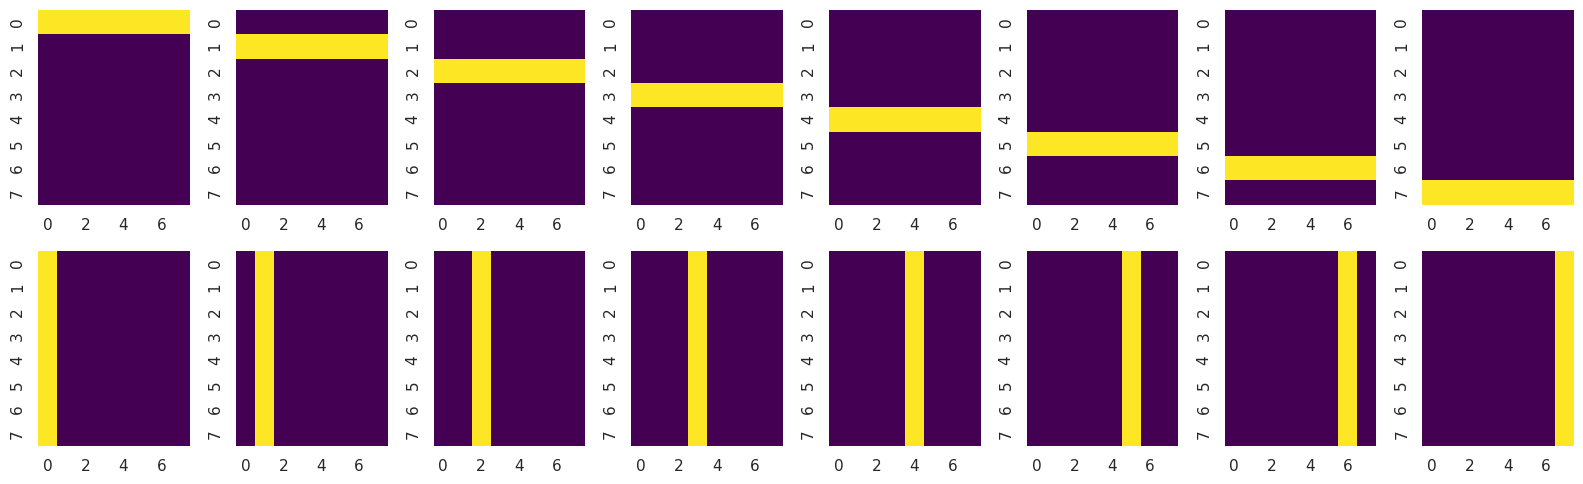

In [3]:
d = 8
tmp = nn.one_hot(jnp.arange(d), d)
W = jnp.stack([ tmp[:, i][:, None].repeat(d, axis=-1) for i in range(d)] + [ tmp[i][None].repeat(d, axis=0) for i in range(d)])

fig, axes = plt.subplots(2, 8, figsize=(16, 5))

for i, w in zip(range(len(W)), W):
    sns.heatmap(w, ax=axes.flatten()[i], cbar=False, vmax=1, vmin=0, cmap='viridis')

fig.tight_layout()

In [4]:
from jax import jit, grad
from jax.scipy.special import erf

@jit
def f(x, a=1.702):
    z = nn.sigmoid(a * x)  # approx for 0.5 * ( 1 + erf(x/jnp.sqrt(2)))
    return - jnp.log(z)

jit_grad_f = jit(grad(f))
print(jit_grad_f(-0.))

%timeit jit_grad_f(-0.)

-0.851
65.9 µs ± 4.11 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


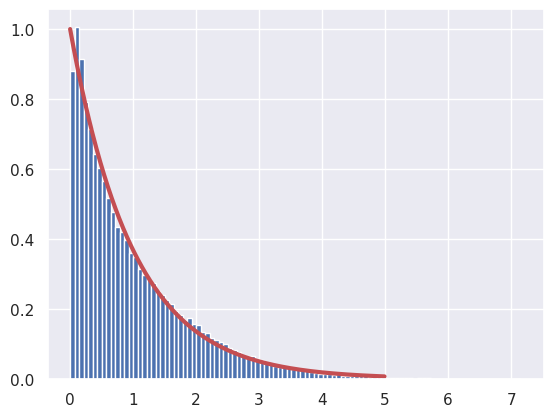

In [5]:
x = random.normal(random.PRNGKey(0), shape=(100_000,))
y = f(-x)
plt.hist(y, bins=100, density=True);
x = jnp.arange(0, 5, 0.01)
plt.plot(x, jnp.exp(-x), 'r', lw=3)

In [6]:
import numpyro
import numpyro.distributions as dist
from numpyro.infer import Predictive
from jax.scipy.special import erfc, erf

scale = 0.5
u = - jnp.log(0.2)

def _model(W, n=100):

    d, k, m = W.shape

    with numpyro.plate('data', n):
        z = numpyro.sample('z', dist.Exponential(1.).expand([d]).to_event(1))
        s = numpyro.deterministic('s', nn.relu( z - u ) )

        loc = (s @ W.reshape(d, -1)).reshape(n, k, m)
        numpyro.sample('obs', dist.Normal(loc, scale).to_event(2))


def global_vars(d, k, m):
    u = numpyro.sample('u', dist.Gamma(1, 1))
    
    sig = numpyro.sample('sig', dist.Gamma(1/2, 1).expand([2]).to_event(1))
    scale = numpyro.deterministic('scale', jnp.sqrt(sig[0]/sig[1]) )

    _v = numpyro.sample('_v', dist.Gamma(1/2, 1).expand([2]).to_event(1))
    v = numpyro.deterministic('v', jnp.sqrt(_v[0]/_v[1]))
    
    _tau = numpyro.sample('_tau', dist.Gamma(1/2, 1).expand([d, 2]).to_event(2))
    tau = numpyro.deterministic('tau', jnp.sqrt(_tau[..., 0]/_tau[..., 1]))
    
    _W = numpyro.sample('W_base', dist.Normal(0, 1).expand([d, k * m]).to_event(2))
    
    s = 1e-2 * v * jnp.expand_dims(tau, -1)
    W = numpyro.deterministic('W', s * _W)
    
    return W.reshape(d, k, m), scale, u

def local_vars(W, scale, u):
    d, k, m = W.shape
    z = numpyro.sample('z', dist.Gamma(1, 1).expand([d]).to_event(1))
    s = numpyro.deterministic('s', nn.relu( z - u ) )

    loc = numpyro.deterministic('loc', (s @ W.reshape(d, -1)).reshape(-1, k, m))
    numpyro.sample('obs', dist.Normal(loc, scale).to_event(2))

def local_vars1(W, scale, u):
    d, k, m = W.shape
    z = numpyro.sample('z', dist.Normal(0, 1).expand([d]).to_event(1))
    s = numpyro.deterministic('s', nn.relu( f(-z) - u ) )

    loc = numpyro.deterministic('loc', (s @ W.reshape(d, -1)).reshape(-1, k, m))
    numpyro.sample('obs', dist.Normal(loc, scale).to_event(2))

def model(n=100, d=16, k=8, m=8):
    W, scale, u = global_vars(d, k, m)
    with numpyro.plate('data', n):
        local_vars(W, scale, u)

def model1(n=100, d=16, k=8, m=8):
    W, scale, u = global_vars(d, k, m)
    with numpyro.plate('data', n):
        local_vars1(W, scale, u)

rng_key = random.PRNGKey(0)
rng_key, _rng_key = random.split(rng_key)
pred = Predictive(_model, num_samples=1)
smpl = pred(_rng_key, W)

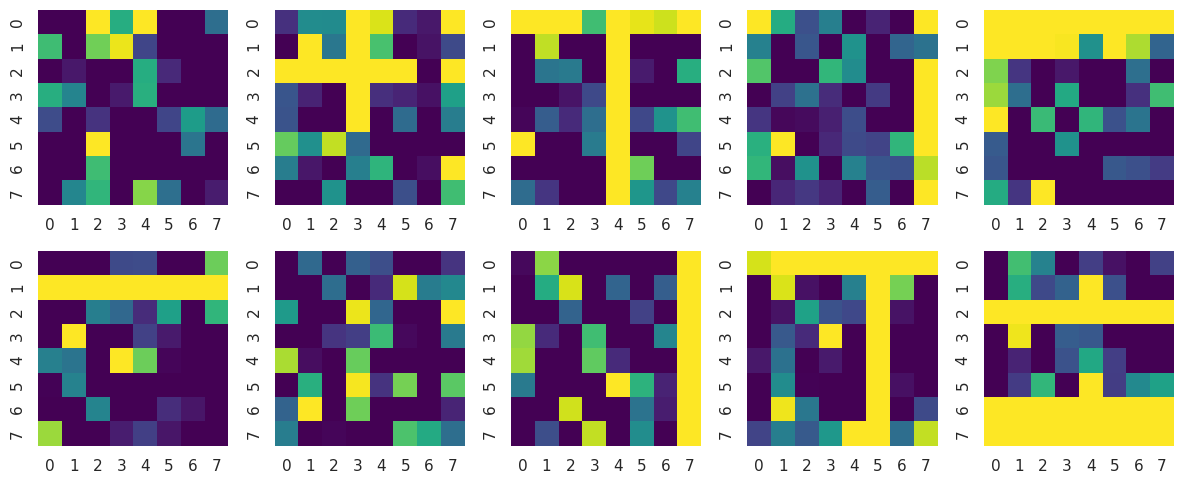

In [7]:
fig, axes = plt.subplots(2, 5, figsize=(12, 5))

O = smpl['obs'][0]

for i, w in enumerate(O[:10]):
    sns.heatmap(w, ax=axes.flatten()[i], cbar=False, vmax=1, vmin=0, cmap='viridis')

fig.tight_layout()

In [8]:
def sample_posterior(model, W, scale, u, obs, key):
    cm = handlers.condition(model, data={'obs': obs})

    mcmc = MCMC(NUTS(cm), num_warmup=200, num_samples=500, progress_bar=False)
    rng_key, _rng_key = random.split(key)
    mcmc.warmup(_rng_key, W, scale, u, collect_warmup=True)
    warm_smpl = mcmc.get_samples()
    rng_key, _rng_key = random.split(rng_key)
    mcmc.run(_rng_key, W, scale, u)
    post_smpl = mcmc.get_samples()

    return {'s': jnp.concatenate([warm_smpl['s'], post_smpl['s']], axis=0), "z": post_smpl["z"]}

obs = smpl['obs'][0]
n = obs.shape[0]

In [9]:
rng_key, _rng_key = random.split(rng_key)
smpl_post = partial(sample_posterior, local_vars, W, scale, u)
post_smpls1 = vmap(smpl_post)(obs, random.split(_rng_key, n))

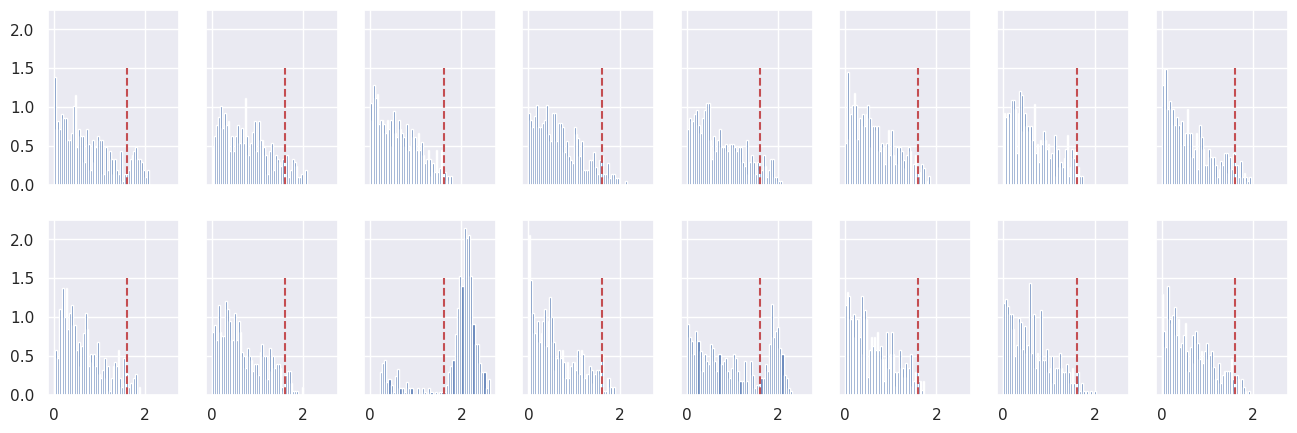

In [10]:
fig, axes = plt.subplots(2, 8, figsize=(16, 5), sharex=True, sharey=True)

k = 0
for i, ax in enumerate(axes.flatten()):
    ax.hist(post_smpls1["z"][k, :, i], bins=50, density=True)
    ax.vlines(u, 0, 1.5, color="r", linestyles="--")

In [11]:
rng_key, _rng_key = random.split(rng_key)
smpl_post = partial(sample_posterior, local_vars1, W, scale, u)
post_smpls2 = vmap(smpl_post)(obs, random.split(_rng_key, n))

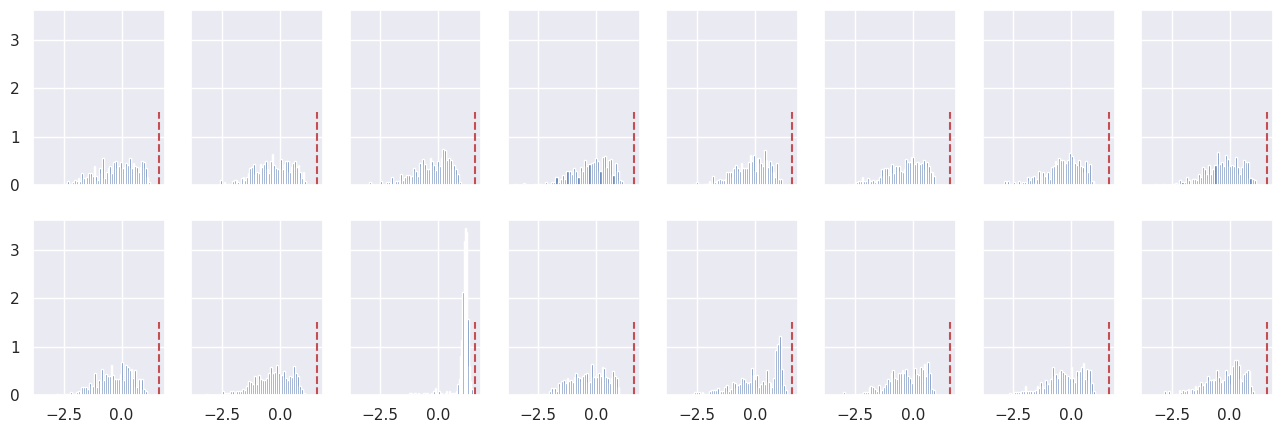

In [12]:
fig, axes = plt.subplots(2, 8, figsize=(16, 5), sharex=True, sharey=True)

k = 0
for i, ax in enumerate(axes.flatten()):
    ax.hist(post_smpls2["z"][k, :, i], bins=50, density=True)
    ax.vlines(u, 0, 1.5, color="r", linestyles="--")

In [ ]:
fix, axes = plt.subplots(1, 3, figsize=(16, 3))

axes[0].plot(post_smpls1["s"].mean(0).mean(-1)[:100])
axes[0].plot(post_smpls2["s"].mean(0).mean(-1)[:100])
axes[0].hlines(0.2, 0, 100, 'r', linestyle='--')
axes[0].set_ylim([.1, .3])

x = jnp.arange(0, 5, 0.01)

s = post_smpls1["s"][:, -200:]
axes[1].hist(s[s > 0], bins=100, density=True);
axes[1].plot(x, jnp.exp(-x), 'r', lw=3);

s = post_smpls2["s"][:, -200:]
axes[2].hist(s[s > 0], bins=100, density=True);
axes[2].plot(x, jnp.exp(-x), 'r', lw=3);


In [ ]:
cm = handlers.condition(model, data={'obs': smpl['obs'][0]})
kernel = NUTS(cm)

mcmc = MCMC(kernel, num_warmup=900, num_samples=100)

rng_key, _rng_key = random.split(rng_key)
mcmc.warmup(_rng_key, collect_warmup=True, d=32)
warm_smpl = mcmc.get_samples()
rng_key, _rng_key = random.split(rng_key)
mcmc.run(random.PRNGKey(0), d=32)

post_smpl = mcmc.get_samples()

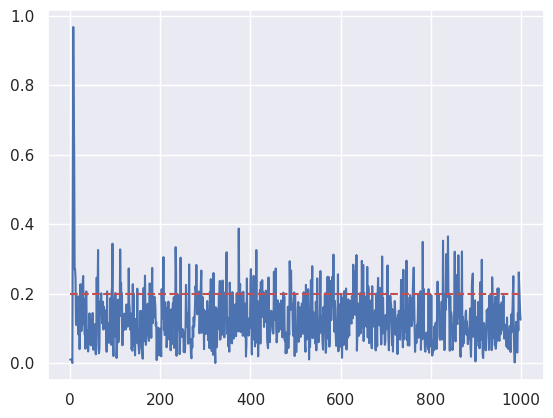

In [ ]:
n = 0
plt.plot( jnp.concatenate([warm_smpl['s'][:, n].mean(-1), post_smpl['s'][:, n].mean(-1)]) )
plt.hlines(0.2, 0, 1000, 'r', linestyle='--')

sample: 100%|██████████| 500/500 [04:32<00:00,  1.84it/s, 1023 steps of size 5.73e-03. acc. prob=0.79]


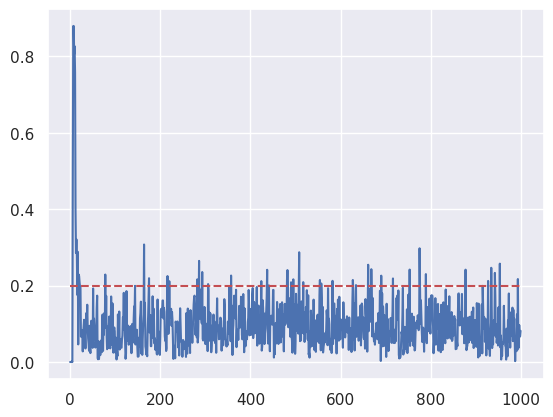

In [9]:
cm = handlers.condition(model1, data={'obs': smpl['obs'][0]})
kernel = NUTS(cm)

mcmc = MCMC(kernel, num_warmup=500, num_samples=500)

rng_key = random.PRNGKey(0) 
rng_key, _rng_key = random.split(rng_key)
mcmc.warmup(_rng_key, collect_warmup=True, d=32)
warm_smpl = mcmc.get_samples()
rng_key, _rng_key = random.split(rng_key)
mcmc.run(random.PRNGKey(0), d=32)

post_smpl = mcmc.get_samples()

n = 0
plt.plot( jnp.concatenate([warm_smpl['s'][:, n].mean(-1), post_smpl['s'][:, n].mean(-1)]) )
plt.hlines(0.2, 0, 1000, 'r', linestyle='--')

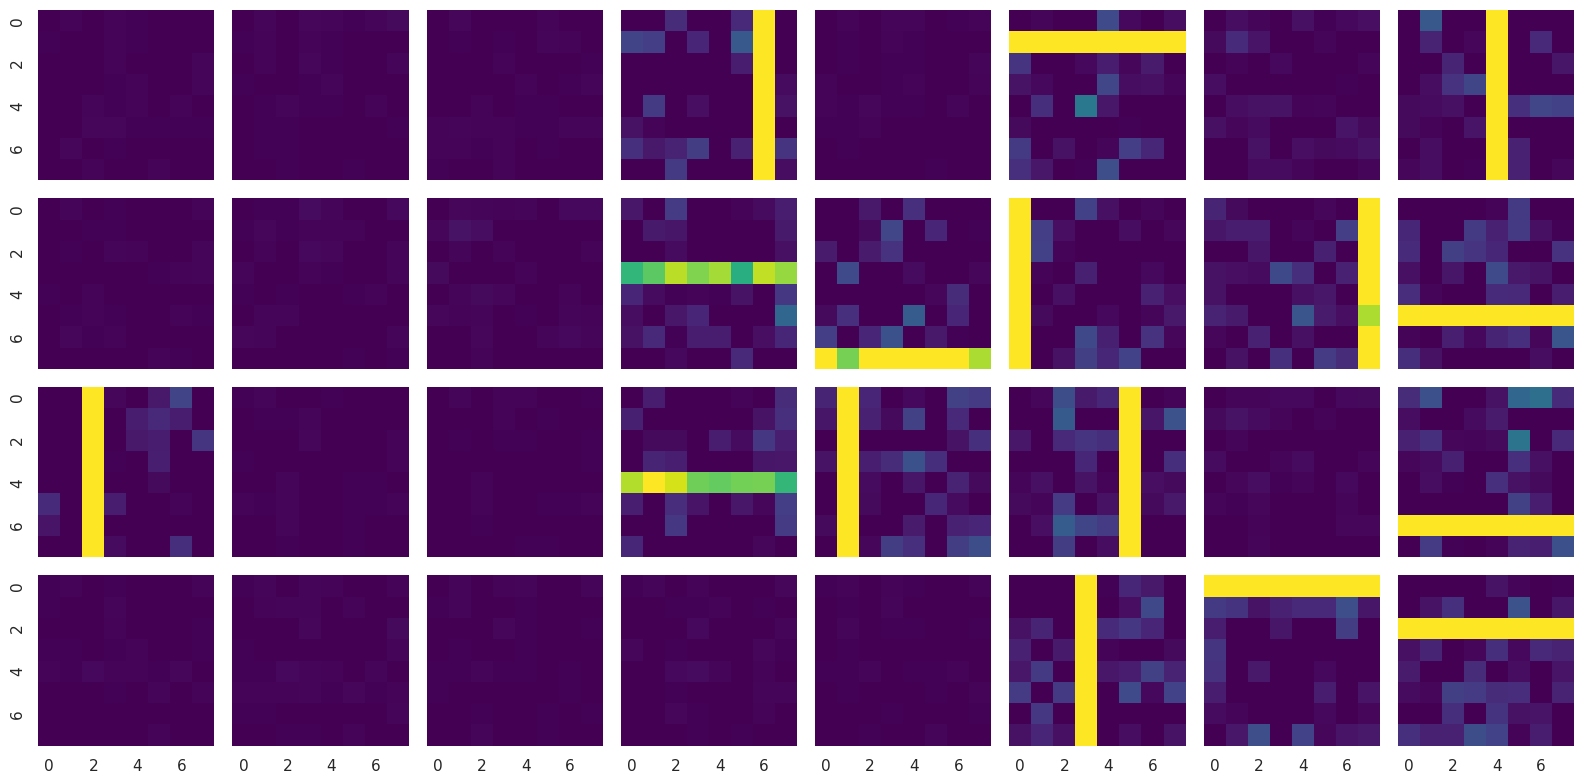

In [13]:
W_post = post_smpl['W'].mean(0).reshape(-1, 8, 8)

fig, axes = plt.subplots(4, 8, figsize=(16, 8), sharex=True, sharey=True)

for i, w in enumerate(W_post):
    sns.heatmap(w, ax=axes.flatten()[i], cbar=False, vmax=1, vmin=0, cmap='viridis')

fig.tight_layout()

In [14]:
print(jnp.mean(post_smpl['s'] > 0), jnp.exp(-u))
jnp.mean(post_smpl['s'].reshape(-1, post_smpl['s'].shape[-1]) > 0, 0)

0.20213124 0.2


Array([0.19584   , 0.19601999, 0.19996   , 0.17186   , 0.19545999,
       0.21068   , 0.203     , 0.21946   , 0.19953999, 0.19858   ,
       0.19671999, 0.19314   , 0.14378   , 0.20852   , 0.23584   ,
       0.20526   , 0.18475999, 0.19856   , 0.19941999, 0.23415999,
       0.21176   , 0.25643998, 0.20082   , 0.21858   , 0.19591999,
       0.19812   , 0.19802   , 0.19538   , 0.19972   , 0.20086   ,
       0.22158   , 0.18044   ], dtype=float32)

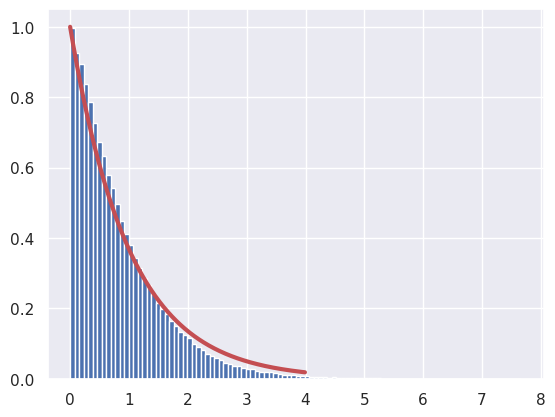

In [15]:
plt.hist(post_smpl['s'][post_smpl['s'] > 0], bins=100, density=True);
x = jnp.arange(0, 4, 0.01)
plt.plot(x, jnp.exp(-x), 'r', lw=3)

In [9]:
from numpyro.infer import SVI, TraceGraph_ELBO, Predictive
from numpyro.optim import optax_to_numpyro
import optax

def svi_sample_posterior(model, guide, W, scale, u, obs, key, num_steps=10_000):
    cm = handlers.condition(model, data={'obs': obs})

    loss = TraceGraph_ELBO(16)
    optimizer = optax_to_numpyro(optax.adabelief(learning_rate=1e-3))

    svi = SVI(cm, guide, optimizer, loss)
    key, _key = random.split(key)
    svi_res = svi.run(_key, num_steps,  W, scale, u, progress_bar=False)

    key, _key = random.split(key)
    samples = Predictive(cm, guide=guide, params=svi_res.params, num_samples=1000, return_sites=["s", "z"])(_key, W, scale, u)

    return svi_res, samples

def local_guide(W, s, u):
    d, k, m = W.shape

    loc = numpyro.param('loc', lambda rng_key: random.normal(rng_key, shape=(d,))/10)
    scale = numpyro.param('scale', jnp.eye(d)/10, constraint=dist.constraints.softplus_lower_cholesky)

    aux = numpyro.sample('aux', dist.MultivariateNormal(loc, scale_tril=scale), infer={'is_auxiliary': True})
    
    v = jnp.exp(aux)
    ld = - aux
    z = numpyro.sample('z', dist.Delta(v, log_density=ld, event_dim=1))
    numpyro.deterministic('s', nn.relu( z - u ) )


def local_guide1(W, s, u):
    d, k, m = W.shape
    loc = numpyro.param('loc', lambda rng_key: random.normal(rng_key, shape=(d,))/10)
    scale = numpyro.param('scale', jnp.eye(d)/10, constraint=dist.constraints.softplus_lower_cholesky)
    z = numpyro.sample('z', dist.MultivariateNormal(loc, scale_tril=scale))
    numpyro.deterministic('s', nn.relu( f(-z) - u ) )

def local_guide2(W, s, u):
    d, k, m = W.shape
    loc = numpyro.param('loc', lambda rng_key: random.normal(rng_key, shape=(d,))/10)
    scale = numpyro.param('scale', jnp.ones(d)/10, constraint=dist.constraints.softplus_positive)
    aux = numpyro.sample('aux', dist.Gumbel(loc, scale=scale).to_event(1), infer={'is_auxiliary': True})

    z = - aux
    z = numpyro.sample('z', dist.Delta(z, log_density=1., event_dim=1))
    numpyro.deterministic('s', nn.relu( f(-z) - u ) )

def local_guide3(W, s, u, l=5):        
    d, k, m = W.shape
    loc = numpyro.param('loc', lambda rng_key: random.normal(rng_key, shape=(d, l,))/10)
    scale = numpyro.param('scale', jnp.ones((d, l)) / 10, constraint=dist.constraints.softplus_positive)
    logits = numpyro.param('probs', jnp.zeros((d, l - 1)))

    mixing_distribution = dist.Categorical(logits=jnp.pad(logits, ((0, 0),(0, 1))) )
    component_distribution = dist.Normal(loc, scale)

    z = numpyro.sample('z', dist.MixtureSameFamily(mixing_distribution, component_distribution).to_event(1))
    numpyro.deterministic('s', nn.relu( f(-z) - u ) )

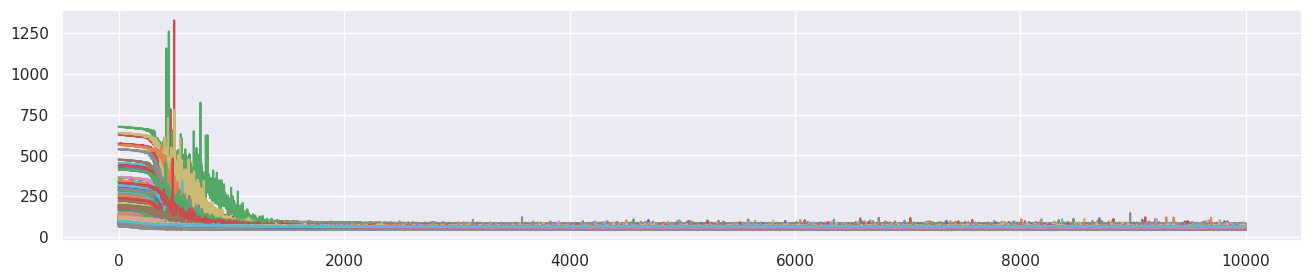

In [51]:
rng_key, _rng_key = random.split(rng_key)
svi_smpl_post = partial(svi_sample_posterior, local_vars, local_guide, W, scale, u)
svi_res, svi_post_smpls1 = vmap(svi_smpl_post)(obs, random.split(_rng_key, n))

plt.figure(figsize=(16, 3));
plt.plot(svi_res.losses.T);

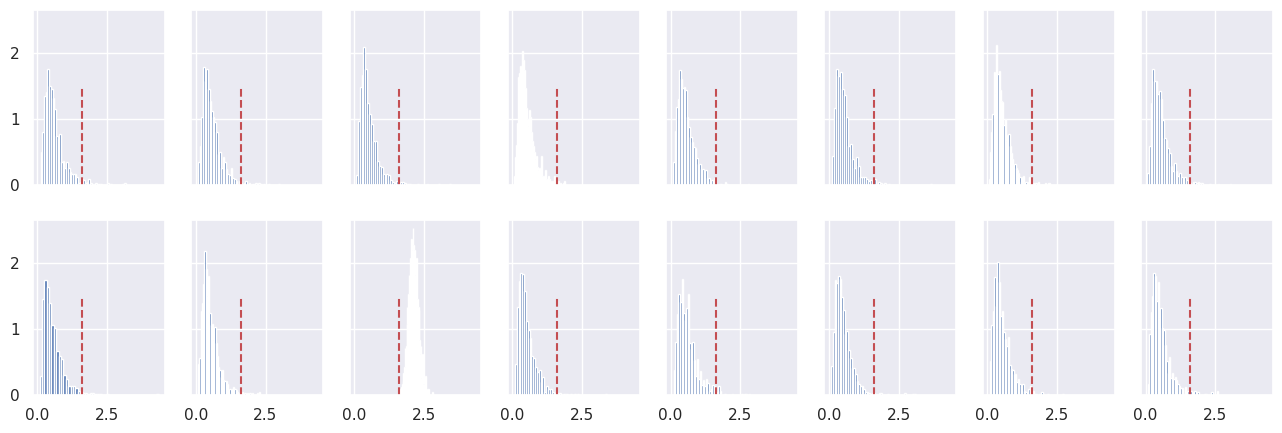

In [52]:
fig, axes = plt.subplots(2, 8, figsize=(16, 5), sharex=True, sharey=True)

k = 0
for i, ax in enumerate(axes.flatten()):
    ax.hist(svi_post_smpls1["z"][k, :, i], bins=50, density=True)
    ax.vlines(u, 0, 1.5, color="r", linestyles="--")

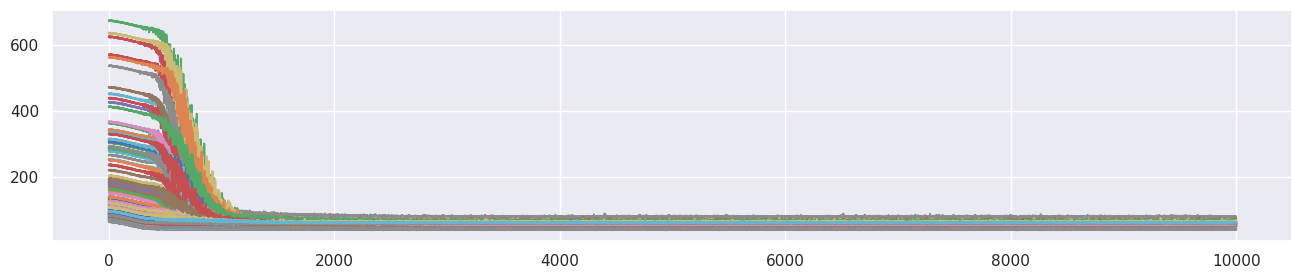

In [53]:
rng_key, _rng_key = random.split(rng_key)
svi_smpl_post = partial(svi_sample_posterior, local_vars1, local_guide1, W, scale, u)
svi_res, svi_post_smpls2 = vmap(svi_smpl_post)(obs, random.split(_rng_key, n))

plt.figure(figsize=(16, 3));
plt.plot(svi_res.losses.T);

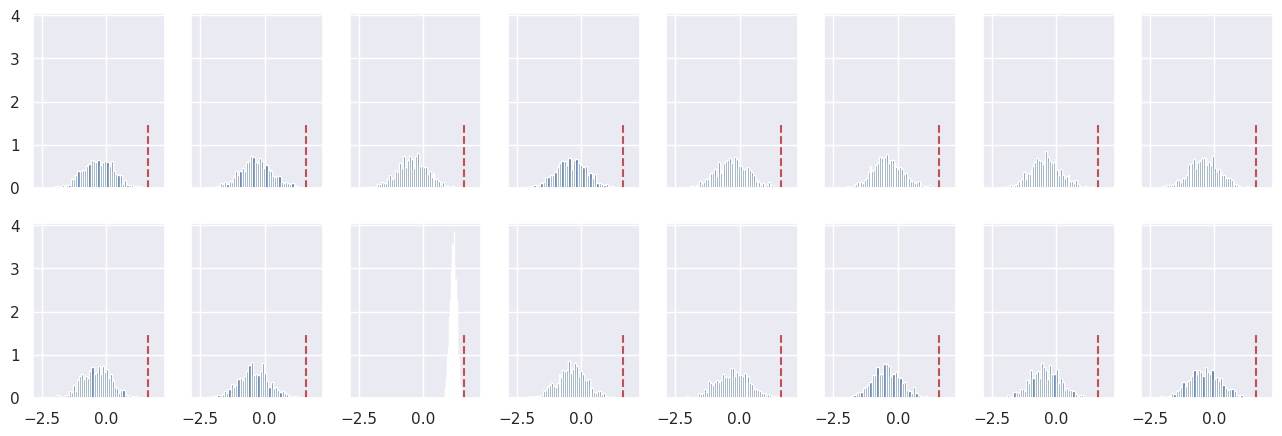

In [54]:
fig, axes = plt.subplots(2, 8, figsize=(16, 5), sharex=True, sharey=True)

k = 0
for i, ax in enumerate(axes.flatten()):
    ax.hist(svi_post_smpls2["z"][k, :, i], bins=50, density=True)
    ax.vlines(u, 0, 1.5, color="r", linestyles="--")

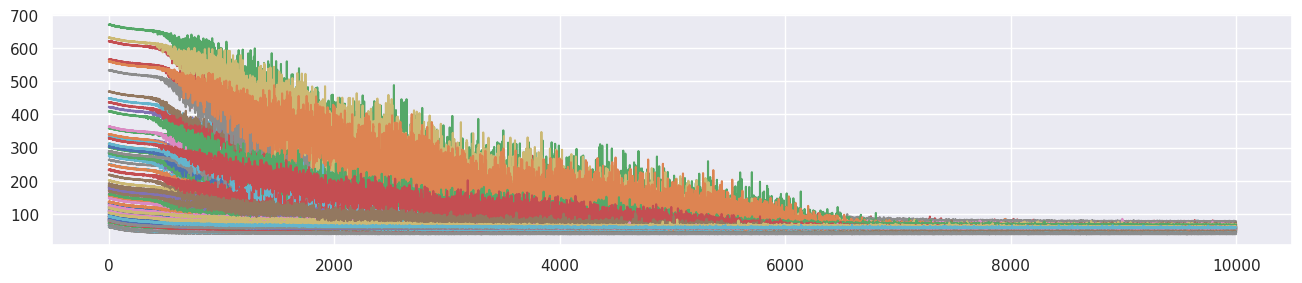

In [61]:
rng_key, _rng_key = random.split(rng_key)
svi_smpl_post = partial(svi_sample_posterior, local_vars1, local_guide3, W, scale, u)
svi_res, svi_post_smpls3 = vmap(svi_smpl_post)(obs, random.split(_rng_key, n))

plt.figure(figsize=(16, 3));
plt.plot(svi_res.losses.T);

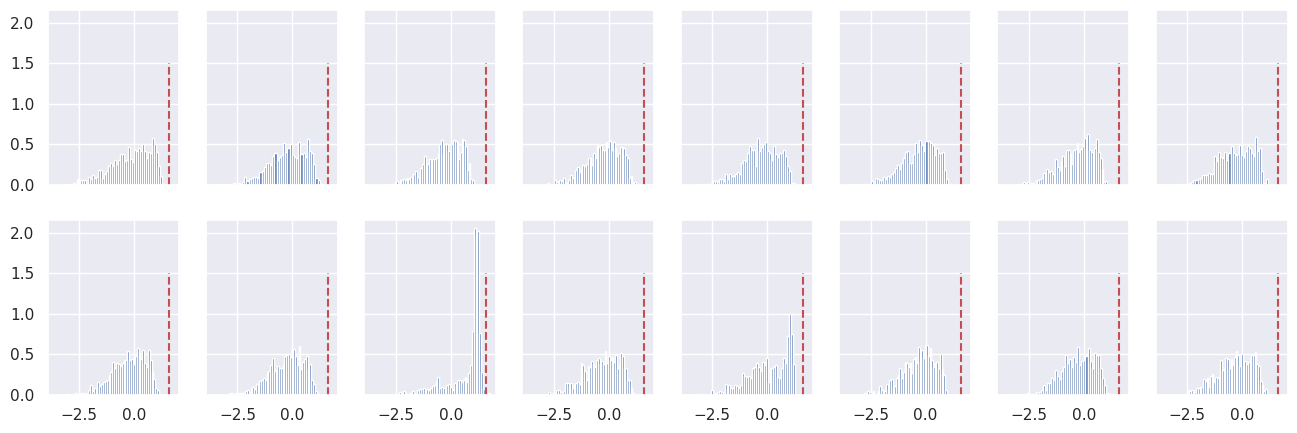

In [62]:
fig, axes = plt.subplots(2, 8, figsize=(16, 5), sharex=True, sharey=True)

k = 0
for i, ax in enumerate(axes.flatten()):
    ax.hist(svi_post_smpls3["z"][k, :, i], bins=50, density=True)
    ax.vlines(u, 0, 1.5, color="r", linestyles="--")

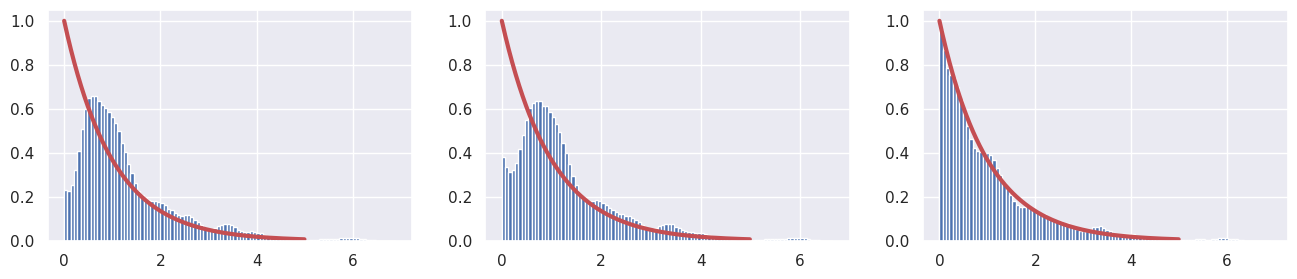

In [63]:
fix, axes = plt.subplots(1, 3, figsize=(16, 3))

x = jnp.arange(0, 5, 0.01)

s = svi_post_smpls1["s"]
axes[0].hist(s[s > 0], bins=100, density=True);
axes[0].plot(x, jnp.exp(-x), 'r', lw=3);

s = svi_post_smpls2["s"]
axes[1].hist(s[s > 0], bins=100, density=True);
axes[1].plot(x, jnp.exp(-x), 'r', lw=3);

s = svi_post_smpls3["s"]
axes[2].hist(s[s > 0], bins=100, density=True);
axes[2].plot(x, jnp.exp(-x), 'r', lw=3);

In [39]:
def local_vars(obs, W, scale, u):
    d, k, m = W.shape
    z = numpyro.sample('z', dist.Normal(0, 1).expand([d]).to_event(1))
    s = numpyro.deterministic('s', nn.relu( f(-z) - u ) )

    loc = numpyro.deterministic('loc', (s @ W.reshape(d, -1)).reshape(-1, k, m))
    numpyro.sample('obs', dist.Normal(loc, scale).to_event(2), obs=obs)

def model(obs, d=16, subsample_size=1000, **kwargs):
    n, k, m = obs.shape
    W, scale, u = global_vars(d, k, m)
    with numpyro.plate('data', n, subsample_size=subsample_size) as idx:
        local_vars(obs[idx], W, scale, u)

def lognormal(name, shape=(), event_dim=0):
    loc = numpyro.param(f'{name}.loc', lambda rng_key: random.normal(rng_key, shape) / 10)
    scale = numpyro.param(f'{name}.scale', jnp.ones(shape), constraint=dist.constraints.softplus_positive)
    return numpyro.sample(name, dist.LogNormal(loc, scale).to_event(event_dim))

def global_guide(d, k, m):
    u = lognormal('u')

    shape = ( (d + 2) * 2,)
    loc = numpyro.param('X.loc', lambda rng_key: random.normal(rng_key, shape) / 10)
    scale_tril = numpyro.param('X.scale_tril', jnp.eye(shape[0]), constraint=dist.constraints.softplus_lower_cholesky)
    
    X = numpyro.sample('X', dist.MultivariateNormal(loc, scale_tril=scale_tril), infer={'is_auxiliary': True})

    X = X.reshape(d + 2, 2)
    
    sig = jnp.exp(X[-1])
    ld = - X[-1].sum()
    sig = numpyro.sample('sig', dist.Delta(sig, ld, 1))
    scale = numpyro.deterministic('scale', jnp.sqrt(sig[0]/sig[1]) )

    _v = jnp.exp(X[-2])
    ld = - X[-2].sum()
    _v = numpyro.sample('_v', dist.Delta(_v, ld, 1))
    v = numpyro.deterministic('v', jnp.sqrt(_v[0]/_v[1]))

    _tau = jnp.exp(X[:-2])
    ld = - X[-2:].sum()
    _tau = numpyro.sample('_tau', dist.Delta(_tau, log_density=ld, event_dim=2))
    tau = numpyro.deterministic('tau', jnp.sqrt(_tau[..., 0]/_tau[..., 1]))
    
    shape = (d, k*m,)
    loc = numpyro.param('W_base.loc', lambda rng_key: random.normal(rng_key, shape) / 10)
    scale_tril_A = numpyro.param('W_base.A', jnp.eye(shape[0]), constraint=dist.constraints.softplus_lower_cholesky)
    scale_tril_B = numpyro.param('W_base.B', jnp.eye(shape[1]), constraint=dist.constraints.softplus_lower_cholesky)
    
    _W = numpyro.sample('W_base', dist.MatrixNormal(loc, scale_tril_A, scale_tril_B))

    s = 1e-2 * v * jnp.expand_dims(tau, -1)
    W = numpyro.deterministic('W', s * _W)
    
    return W.reshape(d, k, m), scale, u

def local_guide(n, d, idx, l=5):        
    loc = numpyro.param('loc', lambda rng_key: random.normal(rng_key, shape=(n, d, l,))/10)
    scale = numpyro.param('scale', jnp.ones((n, d, l)) / 10, constraint=dist.constraints.softplus_positive)
    logits = numpyro.param('probs', jnp.zeros((n, d, l - 1)))
    logits = jnp.pad(logits, ((0, 0), (0, 0), (0, 1)))
    
    mixing_distribution = dist.Categorical(logits=logits[idx])
    component_distribution = dist.Normal(loc[idx], scale[idx])

    numpyro.sample('z', dist.MixtureSameFamily(mixing_distribution, component_distribution).to_event(1))

@jit
def log_abs_grad_f(x, a=1.702):
    return jnp.log( a * nn.sigmoid(- a * x) )

def guide(obs, d=16, subsample_size=1000, l=5):
    n, k, m = obs.shape
    W, scale, u = global_guide(d, k, m)
    with numpyro.plate('data', n, subsample_size=subsample_size) as idx:
        local_guide(n, d, idx, l=l)

rng_key, _rng_key = random.split(rng_key)
pred = Predictive(_model, num_samples=1)
smpl = pred(_rng_key, W, n=10_000)
obs = smpl['obs'][0]
n = obs.shape[0]

with handlers.seed(rng_seed=0):
    model(obs)
    guide(obs)

In [40]:
num_steps = 100_000

loss = TraceGraph_ELBO(10)
optimizer = optax_to_numpyro(optax.adabelief(learning_rate=1e-3))

svi = SVI(model, guide, optimizer, loss)
rng_key, _rng_key = random.split(rng_key)
svi_res = svi.run(_rng_key, num_steps, obs, stable_update=True, d=32, subsample_size=1000, l=10)

100%|██████████| 100000/100000 [16:18<00:00, 102.20it/s, init loss: 1647419.6250, avg. loss [95001-100000]: 576253.8125]


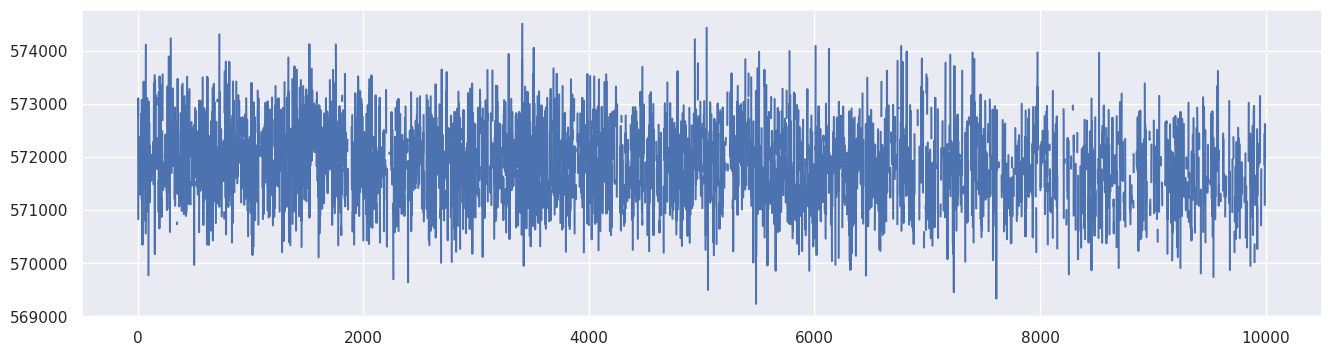

In [32]:
plt.figure(figsize=(16, 4))
plt.plot(svi_res.losses[-10_000:])

In [33]:
rng_key, _rng_key = random.split(rng_key)
svi_smpl = Predictive(model, guide=guide, params=svi_res.params, num_samples=100)(_rng_key, obs, d=32, subsample_size=100)

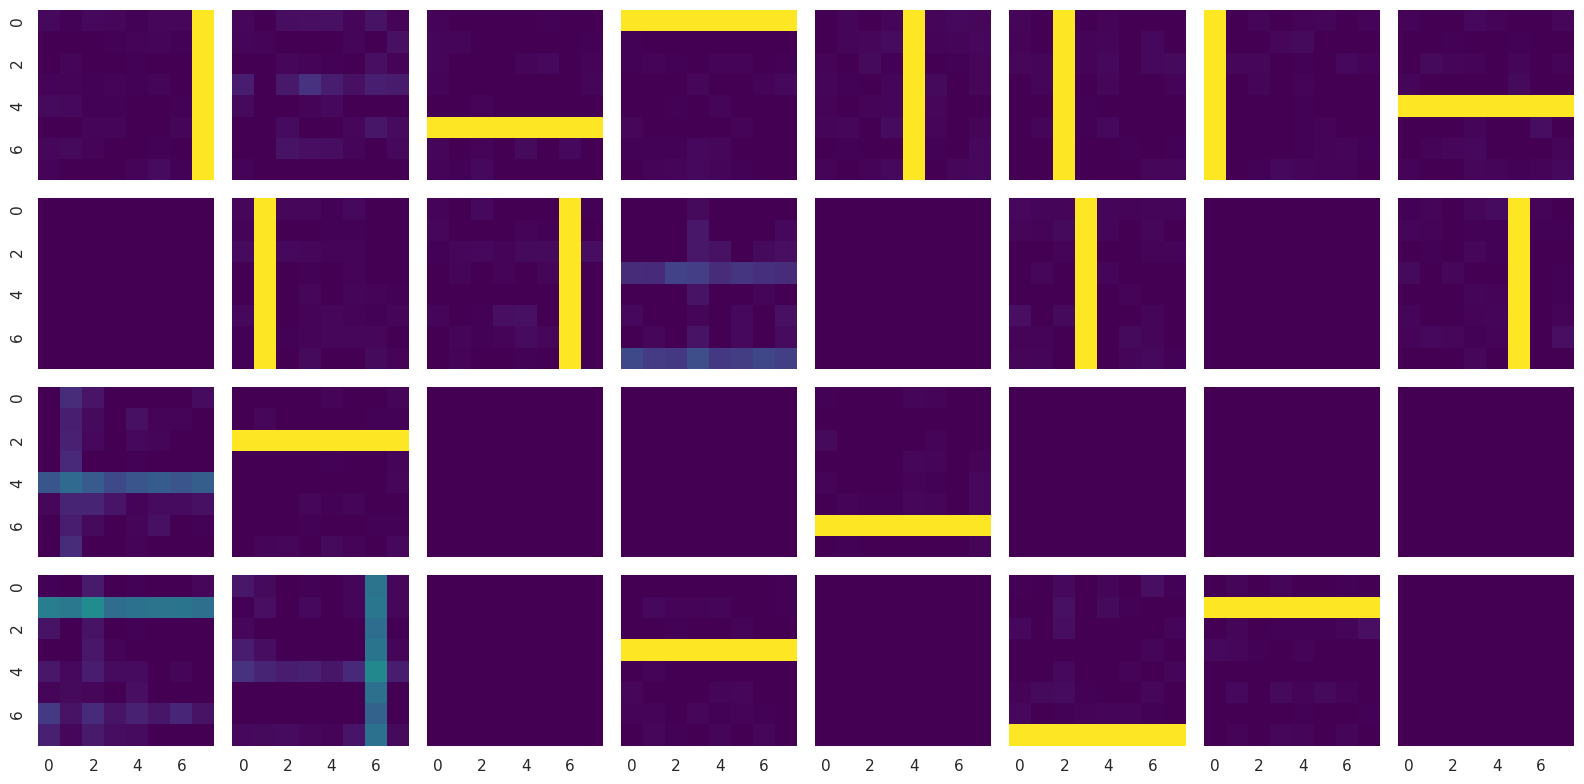

In [35]:
W_post = svi_smpl['W'].mean(0)

fig, axes = plt.subplots(4, 8, figsize=(16, 8), sharex=True, sharey=True)

for i, w in enumerate(W_post):
    sns.heatmap(w.reshape(8, 8), ax=axes.flatten()[i], cbar=False, vmax=1, vmin=0, cmap='viridis')

fig.tight_layout()

In [36]:
print(jnp.mean(svi_smpl['s'] > 0), jnp.exp(-u))
jnp.mean(svi_smpl['s'].reshape(-1, svi_smpl['s'].shape[-1]) > 0, 0)

0.15557188 0.2


Array([0.166     , 0.15689999, 0.1637    , 0.16929999, 0.1633    ,
       0.1708    , 0.1585    , 0.1374    , 0.1653    , 0.16139999,
       0.13      , 0.1486    , 0.15349999, 0.1574    , 0.1608    ,
       0.16139999, 0.1485    , 0.1582    , 0.1607    , 0.16399999,
       0.15359999, 0.1648    , 0.161     , 0.162     , 0.1399    ,
       0.13859999, 0.16399999, 0.1445    , 0.1643    , 0.1443    ,
       0.1276    , 0.15799999], dtype=float32)

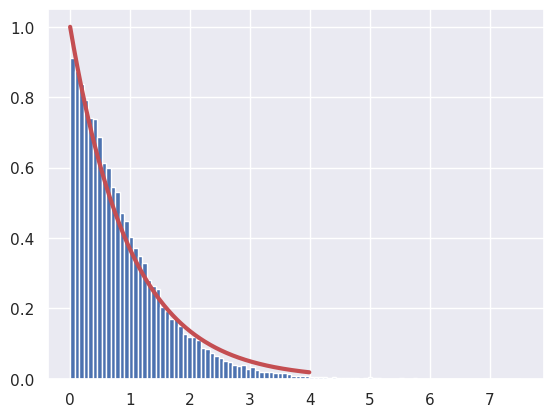

In [37]:
plt.hist(svi_smpl['s'][svi_smpl['s'] > 0], bins=100, density=True);
x = jnp.arange(0, 4, 0.01)
plt.plot(x, jnp.exp(-x), 'r', lw=3)

In [41]:
class AttentionBlock(fnn.Module):
    embed_dim : int   # Dimensionality of input and attention feature vectors
    hidden_dim : int  # Dimensionality of hidden layer in feed-forward network
    num_heads : int   # Number of heads to use in the Multi-Head Attention block
    dropout_prob : float = 0.0  # Amount of dropout to apply in the feed-forward network

    def setup(self):
        self.attn = fnn.MultiHeadDotProductAttention(num_heads=self.num_heads)
        self.linear = [
            fnn.Dense(self.hidden_dim),
            fnn.gelu,
            fnn.Dropout(self.dropout_prob),
            fnn.Dense(self.embed_dim)
        ]
        self.layer_norm_1 = fnn.LayerNorm()
        self.layer_norm_2 = fnn.LayerNorm()
        self.dropout = fnn.Dropout(self.dropout_prob)

    def __call__(self, x, train=True):
        inp_x = self.layer_norm_1(x)
        attn_out = self.attn(inputs_q=inp_x, inputs_kv=inp_x)
        x = x + self.dropout(attn_out, deterministic=not train)

        linear_out = self.layer_norm_2(x)
        for l in self.linear:
            linear_out = l(linear_out) if not isinstance(l, fnn.Dropout) else l(linear_out, deterministic=not train)
        x = x + self.dropout(linear_out, deterministic=not train)
        return x
    
class VisionTransformer(fnn.Module):
    embed_dim : int     # Dimensionality of input and attention feature vectors
    hidden_dim : int    # Dimensionality of hidden layer in feed-forward network
    num_heads : int     # Number of heads to use in the Multi-Head Attention block
    num_layers : int    # Number of layers to use in the Transformer
    num_output : int    # Number of parameters to predict
    num_neurons : int   # Maximum number of encoding neurons 
    dropout_prob : float = 0.0  # Amount of dropout to apply in the feed-forward network

    def setup(self):
        # Layers/Networks
        self.input_layer = fnn.Dense(self.embed_dim)
        self.transformer = [AttentionBlock(self.embed_dim,
                                           self.hidden_dim,
                                           self.num_heads,
                                           self.dropout_prob) for _ in range(self.num_layers)]
        self.mlp_head = fnn.Sequential([
            fnn.LayerNorm(),
            fnn.Dense(self.num_output)
        ])
        self.dropout = fnn.Dropout(self.dropout_prob)

        # # Parameters/Embeddings
        # self.pos_embedding = self.param('pos_embedding',
        #                                 fnn.initializers.normal(stddev=1.0),
        #                                 (1, self.num_neurons, self.embed_dim))


    def __call__(self, x, train=True):
        # Preprocess input
        B, T, _ = x.shape
        x = self.input_layer(x)

        # Add positional encoding
        # x = x + self.pos_embedding

        # Apply Transforrmer
        x = self.dropout(x, deterministic=not train)
        for attn_block in self.transformer:
            x = attn_block(x, train=train)

        # Fix output to the number of parameters
        out = self.mlp_head(x)
        return out

from math import prod
import jax.tree_util as jtu
def count_params(params):
    param_numbers = jtu.tree_map(lambda x: prod(x.shape), params)
    vals, _ = jtu.tree_flatten(param_numbers)
    return sum(vals)
    
## Test VisionTransformer implementation
# Example features as input
d = 32
l = 4

input_dim = 2 * (2 * l + l - 1)
main_rng, x_rng = random.split(rng_key)
x = random.normal(x_rng, (5, d, input_dim))
# Create vision transformer
visntrans = VisionTransformer(embed_dim=32,
                              hidden_dim=64,
                              num_heads=8,
                              num_layers=1,
                              num_output=input_dim // 2,
                              num_neurons=d,
                              dropout_prob=0.1)

# Initialize parameters of the Vision Transformer with random key and inputs
main_rng, init_rng, dropout_init_rng = random.split(main_rng, 3)
params = visntrans.init({'params': init_rng, 'dropout': dropout_init_rng}, x, True)['params']
print(count_params(params))

# Apply encoder block with parameters on the inputs
# Since dropout is stochastic, we need to pass a rng to the forward
main_rng, dropout_apply_rng = random.split(main_rng)
out = visntrans.apply({'params': params}, x, train=True, rngs={'dropout': dropout_apply_rng})
print('Out', out.shape)

del visntrans, params

9707
Out (5, 32, 11)


In [57]:
from numpyro.contrib.module import flax_module
from jax import lax

def local_vars(obs, W, scale, u, **kwargs):
    d, k, m = W.shape
    z = numpyro.sample('z', dist.Normal(0, 1).expand([d]).to_event(1))
    s = numpyro.deterministic('s', nn.relu( f(-z) - u ) )

    loc = numpyro.deterministic('loc', (s @ W.reshape(d, -1)).reshape(-1, k, m))
    numpyro.sample('obs', dist.Normal(loc, scale).to_event(2), obs=obs)

def _guide(name, loc, scale, logits, *args):
    mixing_distribution = dist.Categorical(logits=logits)
    component_distribution = dist.Normal(loc, scale)
    
    numpyro.sample(name, dist.MixtureSameFamily(mixing_distribution, component_distribution).to_event(1))

def _loss(obs, W, s, u, num_particles, params):
    loc = params['loc'] 
    scale = params['scale'] 
    logits = params['logits']

    loss = TraceGraph_ELBO(num_particles)
    optimizer = optax_to_numpyro(optax.adabelief(learning_rate=1e-3))
    guide = partial(_guide, 'z', loc, scale, logits)
    svi = SVI(local_vars, guide, optimizer, loss)
    svi_state = svi.init(rng_key, obs, W, s, u)
    return svi.evaluate(svi_state, obs, W, s, u)

hyperparams = {
    'embed_dim': 32,
    'hidden_dim': 64,
    'num_heads': 4,
    'num_layers': 2,
    'dropout_prob': 0.1
}

def test_guide(obs, W, s, u, l=5, num_particles=16, train=False, num_iter=1):        
    d, k, m = W.shape
    n, k, m = obs.shape

    loc = numpyro.param('loc0', lambda rng_key: random.normal(rng_key, shape=(d, l,))/10)
    scale = numpyro.param('scale0', jnp.ones((d, l)) / 10, constraint=dist.constraints.softplus_positive)
    logits = numpyro.param('logits0', jnp.zeros((d, l - 1)))
    logits = jnp.pad(logits, ((0, 0),(0, 1)))

    params = {
        'loc': jnp.broadcast_to(loc, (n,) + loc.shape),
        'scale': jnp.broadcast_to(scale, (n,) + scale.shape),
        'logits': jnp.broadcast_to(logits, (n,) + logits.shape)
    }

    input_dim = 2 * 3 * l
    rnn = flax_module(
            "rnn",
            VisionTransformer(embed_dim=hyperparams["embed_dim"],
                              hidden_dim=hyperparams['hidden_dim'],
                              num_heads=hyperparams['num_heads'],
                              num_layers=hyperparams['num_layers'],
                              num_output=input_dim // 2,
                              num_neurons=d,
                              dropout_prob=hyperparams['dropout_prob']),
            input_shape=(n, d, input_dim),
            # ensure PRNGKey is made available to dropout layers
            apply_rng=["dropout"],
            # to ensure proper initialisation of LayerNorm we must
            # initialise with train=True
            train=True,
        )
    
    rng_key = numpyro.prng_key()
    
    loss = lambda p, o: _loss(o, W, s, u, num_particles, p)
    with handlers.block():
        def step_fn(carry, t):
            params, rng_key = carry
            out, aux = jtu.tree_flatten(params)
            param_vals = jnp.concatenate(out, -1)
            
            grad_params = vmap(grad(loss))(params, obs)
            out, _ = jtu.tree_flatten(grad_params)
            grad_vals = jnp.concatenate(out, -1)

            batch_input = jnp.concatenate([param_vals, grad_vals], -1)
            rng_key, key = random.split(rng_key)
            output = rnn(
                batch_input, train, rngs={"dropout": key}
            )
            leaves = [output[..., :l], output[..., l:2*l], output[..., 2*l:]]
            params = jtu.tree_unflatten(aux, leaves)
            params['scale'] = nn.softplus(params['scale'])

            return (params, rng_key), None
        
        (params, _), _ = lax.scan(step_fn, (params, rng_key), jnp.arange(num_iter))

    _guide('z', params['loc'], params['scale'], params['logits'])


def iai_guide(obs, d=16, subsample_size=64, train=False, l=5, num_iter=1, num_particles=16):
    n, k, m = obs.shape
    W, scale, u = global_guide(d, k, m)
    with numpyro.plate('data', n, subsample_size=subsample_size) as idx:
        batch_obs = numpyro.subsample(obs, event_dim=2)
        test_guide(batch_obs, W, scale, u, l=l, num_particles=num_particles, train=train, num_iter=num_iter)

with handlers.seed(rng_seed=0):
    test_guide(obs[:1], W, scale, u)
    guide(obs)

100%|██████████| 10000/10000 [00:30<00:00, 324.30it/s, init loss: 227.7496, avg. loss [9501-10000]: 48.7005]


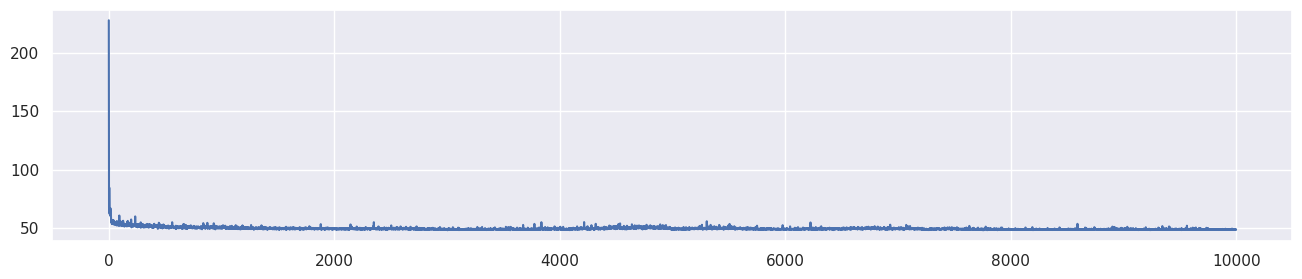

In [58]:
num_steps = 10_000

loss = TraceGraph_ELBO(16)
optimizer = optax_to_numpyro(optax.adabelief(learning_rate=1e-3))

l = 5
num_iter = 1
svi = SVI(local_vars, test_guide, optimizer, loss)
rng_key, _rng_key = random.split(rng_key)
svi_res = svi.run(_rng_key, num_steps, obs[:1], W, scale, u, progress_bar=True, l=l, num_iter=num_iter, train=True)

rng_key, _rng_key = random.split(rng_key)
pred = Predictive(test_guide, params=svi_res.params, num_samples=1000)
iai_smpl = pred(_rng_key, obs[:1], W, scale, u, l=l, num_iter=num_iter, train=False)

plt.figure(figsize=(16, 3))
plt.plot(svi_res.losses);

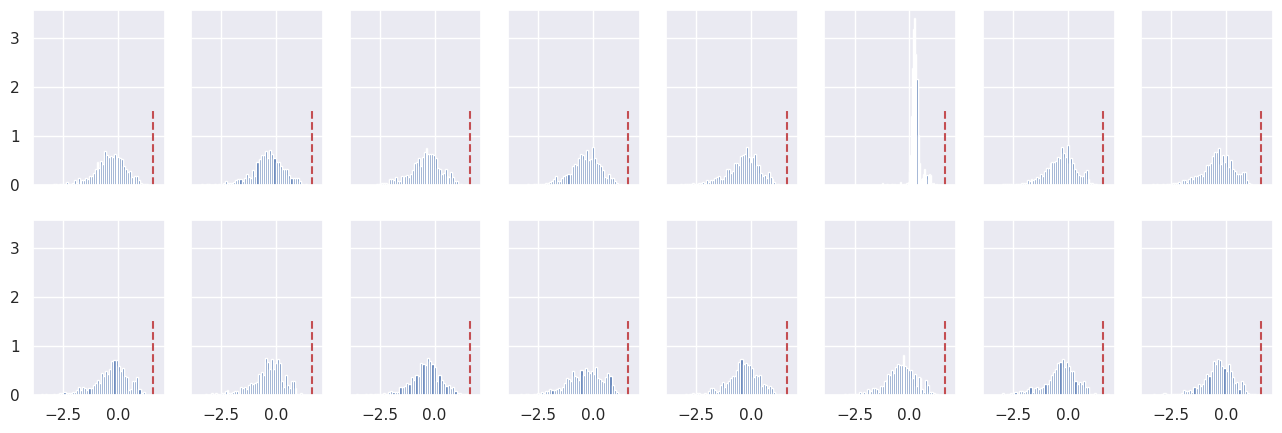

In [45]:
fig, axes = plt.subplots(2, 8, figsize=(16, 5), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    ax.hist(iai_smpl["z"][:, 0, i], bins=50, density=True)
    ax.vlines(u, 0, 1.5, color="r", linestyles="--")

In [59]:
num_steps = 100_000

loss = TraceGraph_ELBO(10)
optimizer = optax_to_numpyro(optax.adabelief(learning_rate=1e-3))

svi = SVI(model, iai_guide, optimizer, loss)
rng_key, _rng_key = random.split(rng_key)
opts = {
    'train': True,
    'num_particles': 5,
    'num_iter': 1,
    'l': 5
}

n = 100
svi_res = svi.run(_rng_key, num_steps, obs, stable_update=True, d=32, subsample_size=128, **opts)

100%|██████████| 100000/100000 [19:33<00:00, 85.25it/s, init loss: 2725247.0000, avg. loss [95001-100000]: -3786984884338465701888.0000]


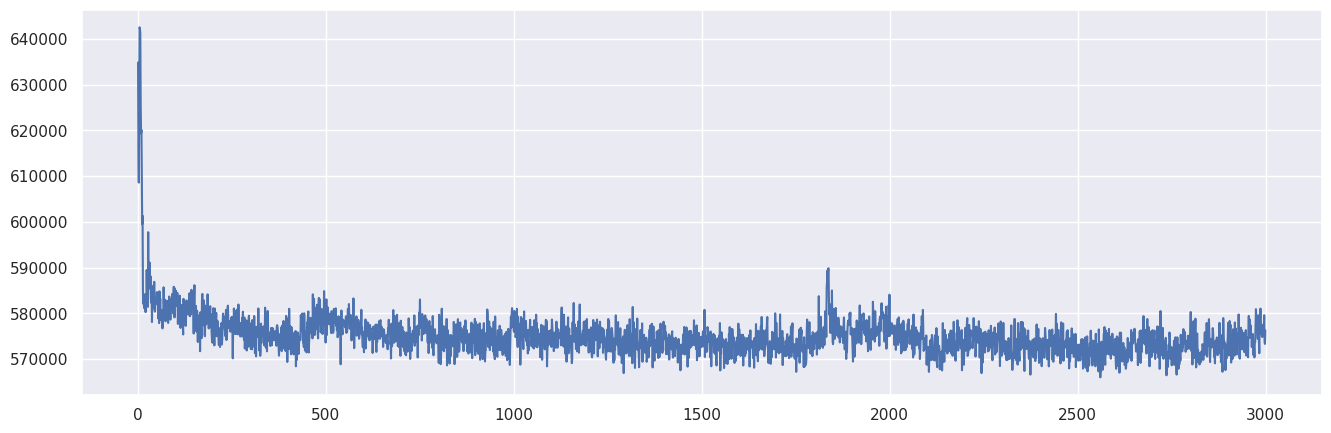

In [64]:
plt.figure(figsize=(16, 5))
plt.plot(svi_res.losses[20_000:23_000])

In [70]:
rng_key, _rng_key = random.split(rng_key)

opts['train'] = False
pred = Predictive(model, guide=iai_guide, params=svi_res.params, num_samples=1000, return_sites=['u', 'scale', 'W', 'z', 's'])
svi_smpl = pred(_rng_key, obs, d=32, subsample_size=400, **opts)

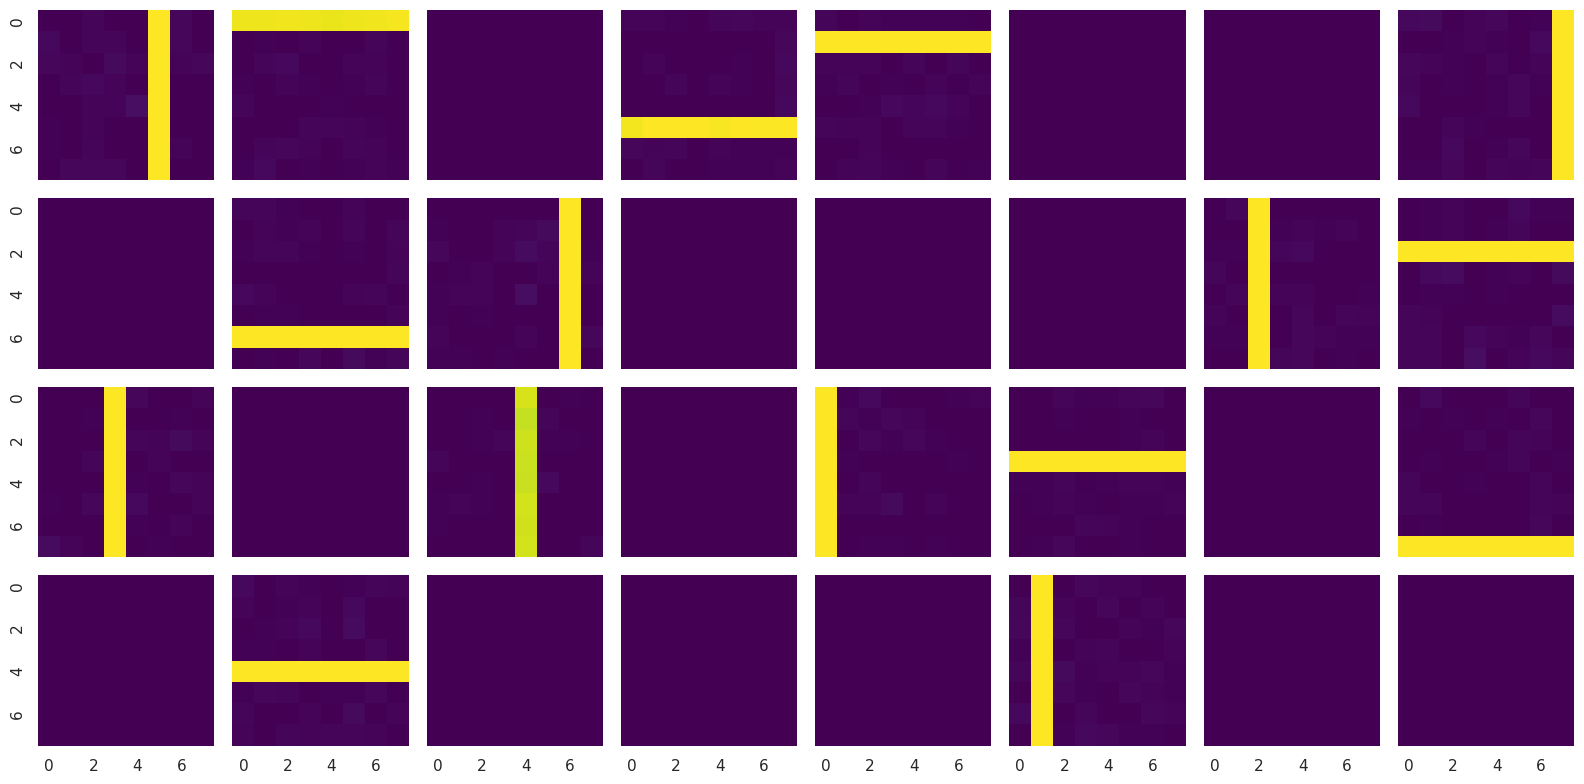

In [55]:
W_post = svi_smpl['W'].mean(0)

fig, axes = plt.subplots(4, 8, figsize=(16, 8), sharex=True, sharey=True)

for i, w in enumerate(W_post):
    sns.heatmap(w.reshape(8, 8), ax=axes.flatten()[i], cbar=False, vmax=1, vmin=0, cmap='viridis')

fig.tight_layout()

In [71]:
print(jnp.mean(svi_smpl['s'] > 0), jnp.exp(-u))
jnp.mean(svi_smpl['s'].reshape(-1, svi_smpl['s'].shape[-1]) > 0, 0)

0.21730258 0.2


Array([0.19248   , 0.18162249, 0.0507    , 0.31114748, 0.61263   ,
       0.038225  , 0.13430999, 0.9902    , 0.0715225 , 0.33684748,
       0.313135  , 0.0374925 , 0.1028175 , 0.1202075 , 0.95577496,
       0.091005  , 0.126805  , 0.0791575 , 0.0948675 , 0.0618025 ,
       0.54602   , 0.16311   , 0.117445  , 0.1110075 , 0.0629575 ,
       0.17848499, 0.0796325 , 0.155055  , 0.04583   , 0.46710998,
       0.0522675 , 0.0720125 ], dtype=float32)

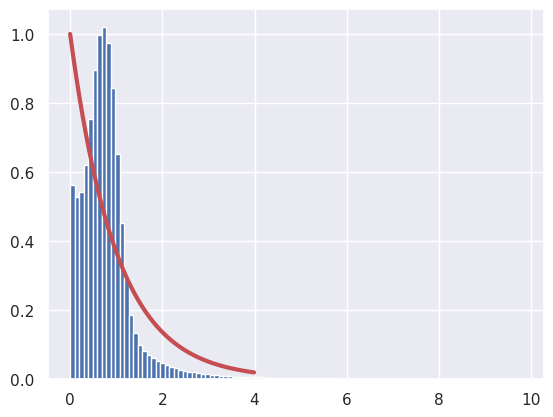

In [68]:
plt.hist(svi_smpl['s'][svi_smpl['s'] > 0], bins=100, density=True);
x = jnp.arange(0, 4, 0.01)
plt.plot(x, jnp.exp(-x), 'r', lw=3)

In [ ]:
assert False

In [ ]:
import equinox as eqx
from typing import Dict, Tuple, Callable
from numpyro.infer import log_likelihood
from jax import grad

def grad_neg_log_prob(z, obs, W, scale, u, lam):
    d, k, m = W.shape
    W = W.reshape(d, -1)
    
    x = jnp.abs(z)
    s = nn.relu(x - u)
    th = jnp.heaviside(x - u, 0.) * jnp.sign(z)
    
    grad_neg_lp = W @ (s @ W - obs.reshape(-1)) * th / scale ** 2 + lam * jnp.sign(z)

    return grad_neg_lp

class GradEnergyPotential(eqx.Module):
    model_args: Tuple
    model_kwargs: Dict
    params: Dict

    def __init__(self, args=(), kwargs={}, params={}):
        self.model_args = args
        self.model_kwargs = kwargs
        self.params = params

    def __call__(self, z, obs):
        return grad_neg_log_prob(z, obs, *self.model_args)

lam = 1
scale = 0.5
args = (W, scale, - jnp.log(0.2) / lam, lam)
grad_ep = GradEnergyPotential(args=args)

rng_key, _rng_key = random.split(rng_key)
z = random.normal(_rng_key, shape=W.shape[:1])
obs = smpl['obs'][0, 0]

%timeit grad_ep( z, obs )
print(grad_ep( z, obs ))

2.03 ms ± 3.24 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
[ 1.        1.        1.       -1.        1.        1.       -1.
 10.644641  1.       -1.        1.       -1.        1.        1.
 -1.        1.      ]


In [ ]:
class VectorField(eqx.Module):
    G: jnp.ndarray
    Q: jnp.ndarray
    nabla_E: Callable

    def __init__(self, dim, args, curl_strength=1.):
        self.G = jnp.eye(dim)
        
        L = dist.LKJCholesky(dim).sample(random.PRNGKey(0), sample_shape=(1,))[0]
        self.Q = curl_strength * (L - L.T)
        
        self.nabla_E = GradEnergyPotential(args=args)

    def __call__(self, t, z, args):
        v = self.nabla_E(z, args['obs'])
        return - self.G @ v - self.Q @ v

lam = 1.
u = - jnp.log(0.2) / lam
scale = 0.5
args = (W, scale, u, lam)
dim = W.shape[0]

vec_field = VectorField(dim, args, curl_strength=.1)

vec_field(0, random.normal(_rng_key, shape=W.shape[:1]), {'obs': smpl['obs'][0, 0]})

Array([ 0.92909086, -0.98851526, -1.0253857 , -1.1087147 ,  0.9571911 ,
       -1.1887827 ,  1.1720684 , -0.92863667,  0.9291013 , -1.0611241 ,
       -0.862831  ,  0.9026149 , -0.92210376,  1.0332586 ,  0.94919074,
        1.0413903 ], dtype=float32)

In [ ]:
from functools import partial 

def activation(u, x):
    return nn.relu(x - u)

class MirrorDescent(eqx.Module):    
    hidden_size: int
    W: Any
    V: Any
    a: Callable
    
    def __init__(self, hidden_size, W, u=-jnp.log(0.2), scale=1, **kwargs):
        super().__init__(**kwargs)
        self.hidden_size = hidden_size
        self.W = W.reshape(hidden_size, -1) / scale ** 2

        self.V = self.W @ self.W.T/scale**2 - jnp.eye(hidden_size)
        self.a = partial(activation, u)
        
    def __call__(self, t, z, args):
        s = self.a(z)
        return - z + self.W @ args['obs'].reshape(-1) - self.V @ s

rng_key = random.PRNGKey(0)
rng_key, _rng_key = random.split(rng_key)

mir_desc = MirrorDescent(W.shape[0], W, scale=0.1)
mir_desc(0, random.normal(_rng_key, shape=W.shape[:1]), {'obs': smpl['obs'][0, 0]})

Array([-2.4432572e+05, -2.4416639e+05, -2.4431745e+05, -2.4431972e+05,
       -2.4431814e+05, -2.4430623e+05, -2.4395770e+05, -2.4432428e+05,
        5.4349274e+02,  3.2123760e+01,  3.1008459e+02,  7.4469598e+02,
       -1.9589141e+06,  8.6031944e+01,  8.4868881e+01,  3.0778323e+03],      dtype=float32)

In [ ]:
from jax import lax

z_dim = W.shape[0]
scale = 1.
mir_desc = MirrorDescent(z_dim, W, scale=scale)
dt = 0.01
s = jnp.sqrt(2)
n = smpl['obs'][0].shape[0]

args = {'obs': smpl['obs'][0]}

def _heun(vec_field, dt, s, z, dW, args):
    g = vec_field(0, z, args)
    _z = z + g * dt + s * dW
    return z + dt * (vec_field(0, _z, args) + g) / 2 + s * dW

heun = partial(_heun, mir_desc, dt, s)

def step_fn(carry, t):
    z, rng_key = carry
    rng_key, _rng_key = random.split(rng_key)
    dW = jnp.sqrt(dt) * random.normal(_rng_key, shape=(n, z_dim))
    z_new = vmap(heun)(z, dW, args)
    return (z_new, rng_key), z_new

rng_key, _rng_key = random.split(rng_key)
z_init = random.normal(_rng_key, shape=(n, z_dim))

last, z = lax.scan(step_fn, (z_init, rng_key), jnp.arange(10_000))
s = mir_desc.a(z)


In [ ]:
z_dim = W.shape[0]
lam = 1.
scale = 0.5
args = (W, scale, - jnp.log(0.2)/lam, lam)
vec_field = VectorField(z_dim, args, curl_strength=10.)

def _heun(vf, dt, s, z, dW, args):
    g = vf(0, z, args)
    _z = z + g * dt + s * dW
    return z + dt * (vf(0, _z, args) + g) / 2 + s * dW

dt = 1e-3
s = jnp.sqrt(2)
heun = partial(_heun, vec_field, dt, s)

n = smpl['obs'].shape[1]

def step_fn(carry, t):
    z, args, rng_key = carry
    rng_key, _rng_key = random.split(rng_key)
    dW = jnp.sqrt(dt) * random.normal(_rng_key, shape=(n, z_dim))
    z_new = vmap(heun)(z, dW, args)
    return (z_new, args, rng_key), z_new

rng_key, _rng_key = random.split(rng_key)
args = {'obs': smpl['obs'][0]}
z_init = jnp.zeros((n ,z_dim)) # random.normal(_rng_key, shape=(n, z_dim))
n_steps = 100_000
last, z = lax.scan(step_fn, (z_init, args, rng_key), jnp.arange(n_steps))

In [ ]:
z.shape

(100000, 100, 16)

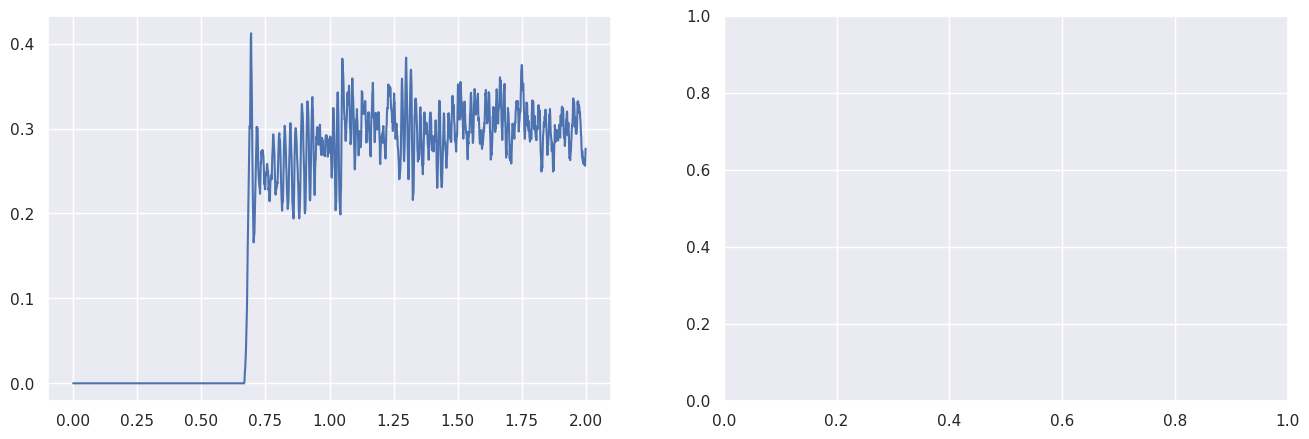

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
s = nn.relu(jnp.abs(z) + jnp.log(0.2))
ts = jnp.arange(n_steps) * dt

axes[0].plot(ts[:2000], s[:2000, 20].mean(-1))
# axes[0].hlines(0.2, 0, ts[-1], 'r', linestyle='--')

# s = s[-100:]
# axes[1].hist(s[s > 0], bins=100, density=True);
# x = jnp.arange(0, 6, 0.01)
# plt.plot(x, jnp.exp(-x), 'r', lw=3)

In [ ]:
import diffrax

class SparseSDE(eqx.Module):
    vf: Callable  # drift
    z_dim: int

    def __init__(
        self,
        vector_field,
        z_dim,
        **kwargs
    ):
        super().__init__(**kwargs)
        self.vf = vector_field
        self.z_dim = z_dim
        
    def __call__(self, ts, dt0, *, obs, key):
        t0 = ts[0]
        t1 = ts[-1]
        
        init_key, bm_key = random.split(key, 2)
        z0 = random.normal(init_key, (self.z_dim,))

        diffusion = lambda t, y, args: jnp.sqrt(2) * jnp.ones(self.z_dim)

        vf = diffrax.ODETerm(self.vf)  # Drift term

        brownian_motion = diffrax.VirtualBrownianTree(
            t0=t0, t1=t1, tol=dt0 / 2, shape=(self.z_dim,), key=bm_key
        )

        terms = diffrax.MultiTerm(vf, diffrax.ControlTerm(diffusion, brownian_motion))

        solver = diffrax.Heun()

        args = {'obs': obs}
        
        saveat = diffrax.SaveAt(ts=ts)
        sol = diffrax.diffeqsolve(terms, solver, t0, t1, dt0, z0, args=args, saveat=saveat, max_steps=1000_000)
        return sol

In [ ]:
z_dim = W.shape[0]
mir_desc = MirrorDescent(z_dim, W, u=-jnp.log(0.2))

args = {'obs': smpl['obs'][0, 0]}

solve_sde = SparseSDE(mir_desc, z_dim, args)
ts = jnp.arange(0, 10, .05)

rng_key, _rng_key = random.split(rng_key)
sol = solve_sde(ts, dt0=0.001, key=_rng_key)

In [ ]:
z_dim = W.shape[0]
lam = 1.
scale = 0.5
u = - jnp.log(0.2)/lam
args = (W, scale, u, lam)

vec_field = VectorField(z_dim, args, curl_strength=0.1)

solve_sde = SparseSDE(vec_field, z_dim)
ts = jnp.arange(0, 5, .01)

dt0 = 5 * 1e-3
rng_key, _rng_key = random.split(rng_key)
ssde = partial(solve_sde, ts, dt0)
sol = vmap(ssde)(key=random.split(_rng_key, smpl['obs'].shape[1]), obs=smpl['obs'][0])

s = nn.relu( jnp.abs(sol.ys) - u)

2023-03-30 18:18:26.958314: E external/org_tensorflow/tensorflow/compiler/xla/python/pjit.cc:606] fastpath_data is none


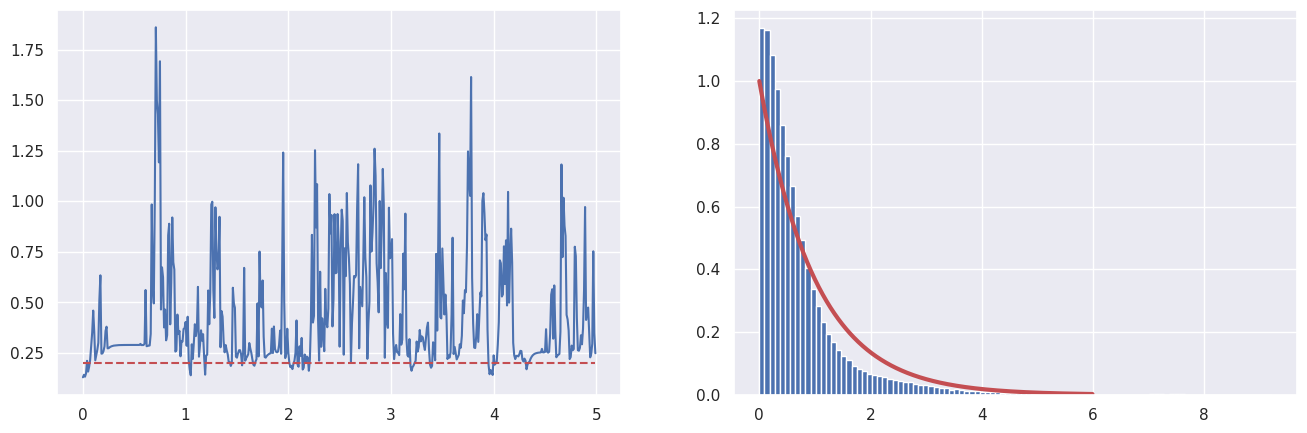

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

axes[0].plot(ts, s[0].mean(-1))
axes[0].hlines(0.2, 0, ts[-1], 'r', linestyle='--')

axes[1].hist(s[s > 0], bins=100, density=True);
x = jnp.arange(0, 6, 0.01)
plt.plot(x, jnp.exp(-x), 'r', lw=3)